--- Hardware & Problem Setup ---
Systolic Array Dimension: 32x32
Input Tensor: (96, 64, 64)
Kernels: 128 kernels of size (96, 3, 3)

--- Step 1: Formulating Logical Matrices ---
Logical Matrix B (Weights) Shape [M, K]: (128, 864)
Logical Matrix A (Inputs) Shape [K, N]: (864, 1024)
Logical Matrix C (Outputs) Shape [M, N]: (128, 1024)



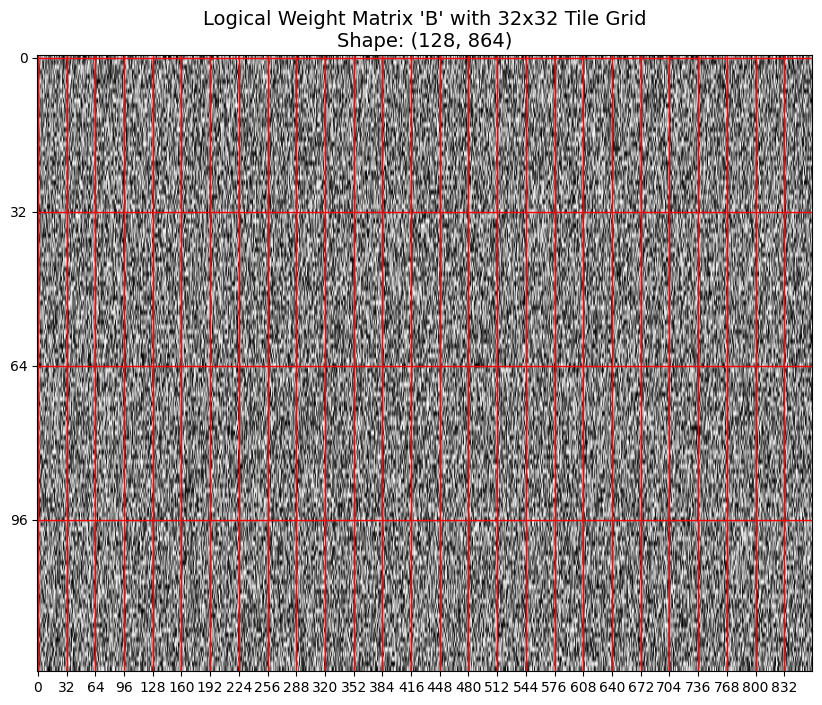

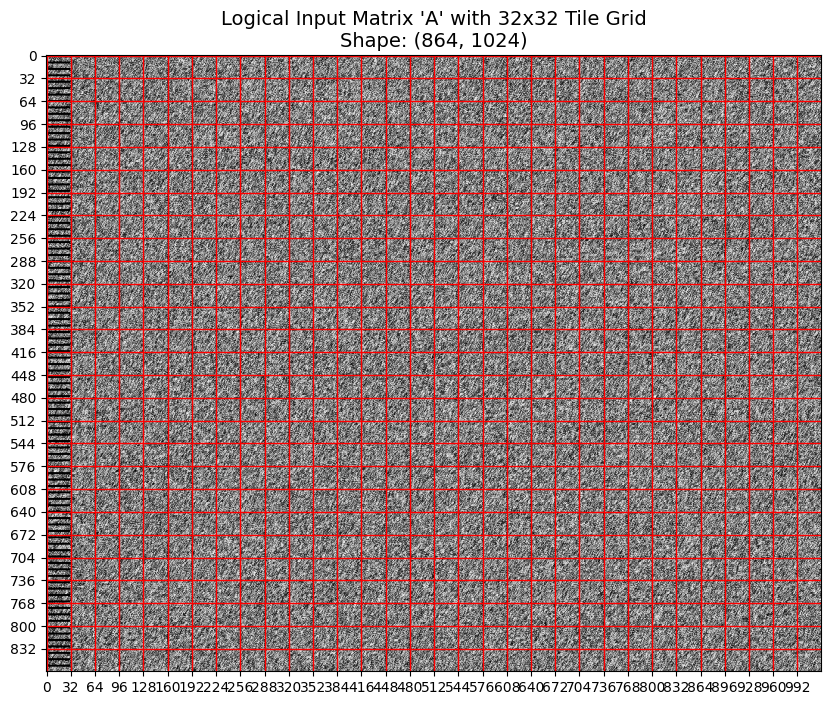

--- Step 2: Simulating Tiled Execution on 32x32 Array ---
Tiling info: M_tiles=4, K_tiles=27, N_tiles=32
Starting tiled matrix multiplication C[M, N] = B[M, K] @ A[K, N]...

  Computing C[0:32, 0:32] += B[0:32, 0:32] @ A[0:32, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 32:64] @ A[32:64, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 64:96] @ A[64:96, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 96:128] @ A[96:128, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 128:160] @ A[128:160, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 160:192] @ A[160:192, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 192:224] @ A[192:224, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 224:256] @ A[224:256, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 256:288] @ A[256:288, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 288:320] @ A[288:320, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 320:352] @ A[320:352, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 352:384] @ A[352:384, 0:32]
  Computing C[0:32, 0:32] += B[0:32, 384:416] @ A[384:416, 0:3

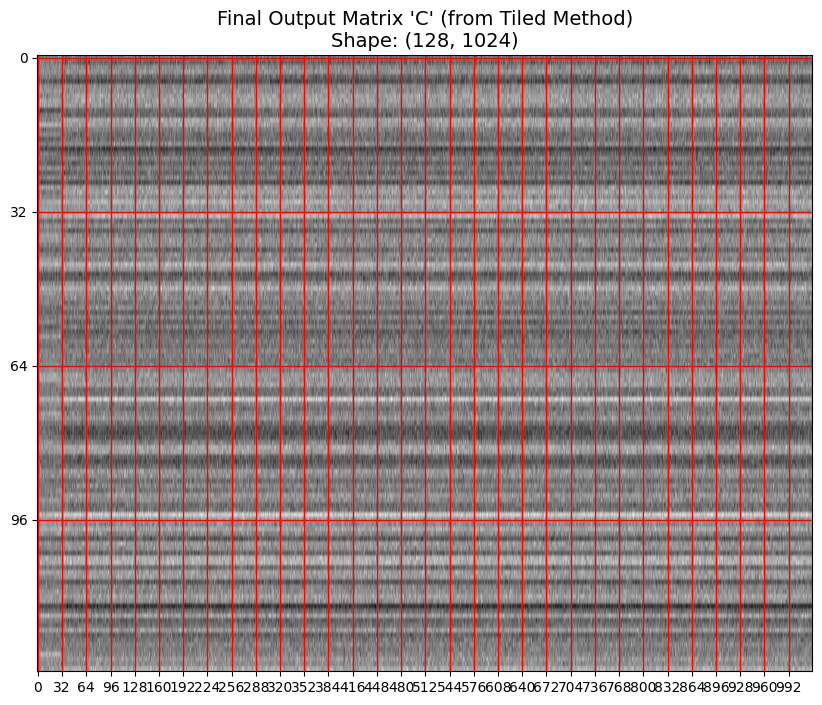

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

# --- 1. Hardware & Problem Definition ---

# Define the fixed hardware dimension
SYSTOLIC_ARRAY_DIM = 32

# Define a larger convolution problem that REQUIRES tiling
IN_HEIGHT = 64
IN_WIDTH = 64
IN_CHANNELS = 96      # Dimension that will be tiled
OUTPUT_CHANNELS = 128 # Dimension that will be tiled
KERNEL_SIZE = 3
STRIDE = 2
PADDING = 1 # Using padding to keep output dimensions the same as input

print(f"--- Hardware & Problem Setup ---")
print(f"Systolic Array Dimension: {SYSTOLIC_ARRAY_DIM}x{SYSTOLIC_ARRAY_DIM}")
print(f"Input Tensor: ({IN_CHANNELS}, {IN_HEIGHT}, {IN_WIDTH})")
print(f"Kernels: {OUTPUT_CHANNELS} kernels of size ({IN_CHANNELS}, {KERNEL_SIZE}, {KERNEL_SIZE})\n")


# --- 2. Helper Functions ---

def im2col(input_data, K, S, P):
    """
    Transforms the input feature map into the logical column matrix 'A'.
    This represents the complete data space that we will tile.
    """
    C, H, W = input_data.shape
    out_h = (H + 2 * P - K) // S + 1
    out_w = (W + 2 * P - K) // S + 1
    
    padded_input = np.pad(input_data, ((0, 0), (P, P), (P, P)), 'constant')
    cols = np.zeros((C * K * K, out_h * out_w))
    
    col_idx = 0
    for y in range(out_h):
        for x in range(out_w):
            patch = padded_input[:, y*S:y*S+K, x*S:x*S+K]
            cols[:, col_idx] = patch.flatten()
            col_idx += 1
    return cols

def flatten_kernels(kernels):
    """
    Flattens the kernel tensor into the logical weight matrix 'B'.
    """
    return kernels.reshape(kernels.shape[0], -1)

def show_matrix_with_tiles(matrix, title):
    """
    Visualizes a matrix in grayscale and overlays a grid representing the
    32x32 tiles that hardware would process.
    """
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(matrix, cmap='gray', aspect='auto')
    
    # Overlay grid for tiles
    ax.set_xticks(np.arange(0, matrix.shape[1], SYSTOLIC_ARRAY_DIM), minor=False)
    ax.set_yticks(np.arange(0, matrix.shape[0], SYSTOLIC_ARRAY_DIM), minor=False)
    ax.grid(which='major', color='r', linestyle='-', linewidth=1)

    ax.set_title(f"{title}\nShape: {matrix.shape}", fontsize=14)
    plt.show()

# --- 3. Logical Matrix Formulation ---
# In a real system, these full matrices are never stored.
# We create them here to simulate slicing tiles from a larger buffer.

print("--- Step 1: Formulating Logical Matrices ---")
# Create random tensors for the simulation
input_tensor = np.random.randint(0, 256, size=(IN_CHANNELS, IN_HEIGHT, IN_WIDTH))
kernel_tensor = np.random.randint(-128, 128, size=(OUTPUT_CHANNELS, IN_CHANNELS, KERNEL_SIZE, KERNEL_SIZE))

# Create the complete logical matrices
logical_A = im2col(input_tensor, KERNEL_SIZE, STRIDE, PADDING)
logical_B = flatten_kernels(kernel_tensor)

# The final output matrix C will be the result of B @ A
# We initialize it with zeros and accumulate results into it.
OUT_HEIGHT = (IN_HEIGHT + 2 * PADDING - KERNEL_SIZE) // STRIDE + 1
OUT_WIDTH = (IN_WIDTH + 2 * PADDING - KERNEL_SIZE) // STRIDE + 1
logical_C = np.zeros((OUTPUT_CHANNELS, OUT_HEIGHT * OUT_WIDTH))

M = logical_B.shape[0]  # Corresponds to OUTPUT_CHANNELS
K = logical_B.shape[1]  # Corresponds to IN_CHANNELS * K * K
N = logical_A.shape[1]  # Corresponds to OUT_HEIGHT * OUT_WIDTH

print(f"Logical Matrix B (Weights) Shape [M, K]: {logical_B.shape}")
print(f"Logical Matrix A (Inputs) Shape [K, N]: {logical_A.shape}")
print(f"Logical Matrix C (Outputs) Shape [M, N]: {logical_C.shape}\n")

# Weight Matrix B: [M, K]
# M = OUTPUT_CHANNELS
# K = IN_CHANNELS * KERNEL_SIZE * KERNEL_SIZE

# Input Matrix A: [K, N]
# K = IN_CHANNELS * KERNEL_SIZE * KERNEL_SIZE
# N = OUT_HEIGHT * OUT_WIDTH

# Output Matrix C: [M, N]
# M = OUTPUT_CHANNELS
# N = OUT_HEIGHT * OUT_WIDTH

# Visualize the full problem space with tile grids
show_matrix_with_tiles(logical_B, "Logical Weight Matrix 'B' with 32x32 Tile Grid")
show_matrix_with_tiles(logical_A, "Logical Input Matrix 'A' with 32x32 Tile Grid")


# --- 4. Tiled Execution Simulation ---
# This loop mimics the hardware controller.

print("--- Step 2: Simulating Tiled Execution on 32x32 Array ---")

# Calculate number of tiles needed for each dimension
m_tiles = math.ceil(M / SYSTOLIC_ARRAY_DIM)
k_tiles = math.ceil(K / SYSTOLIC_ARRAY_DIM)
n_tiles = math.ceil(N / SYSTOLIC_ARRAY_DIM)

print(f"Tiling info: M_tiles={m_tiles}, K_tiles={k_tiles}, N_tiles={n_tiles}")
print("Starting tiled matrix multiplication C[M, N] = B[M, K] @ A[K, N]...\n")

# Loop through the output tiles (output-stationary dataflow)
for m_idx in range(m_tiles):
    for n_idx in range(n_tiles):
        
        # This memory holds the partial sums for one output tile
        output_tile_accumulator = np.zeros((SYSTOLIC_ARRAY_DIM, SYSTOLIC_ARRAY_DIM))
        
        # Loop through the reduction (K) dimension
        for k_idx in range(k_tiles):
            
            # --- "DMA Load" Phase ---
            # Calculate the start and end indices for the current tiles
            m_start = m_idx * SYSTOLIC_ARRAY_DIM
            m_end = min(m_start + SYSTOLIC_ARRAY_DIM, M)
            
            k_start = k_idx * SYSTOLIC_ARRAY_DIM
            k_end = min(k_start + SYSTOLIC_ARRAY_DIM, K)

            n_start = n_idx * SYSTOLIC_ARRAY_DIM
            n_end = min(n_start + SYSTOLIC_ARRAY_DIM, N)

            # Slice the tiles from the logical matrices
            b_tile = logical_B[m_start:m_end, k_start:k_end]
            a_tile = logical_A[k_start:k_end, n_start:n_end]
            
            # --- "Padding" Phase ---
            # Hardware must operate on full 32x32 blocks. Pad if necessary.
            padded_b_tile = np.zeros((SYSTOLIC_ARRAY_DIM, SYSTOLIC_ARRAY_DIM))
            padded_b_tile[:b_tile.shape[0], :b_tile.shape[1]] = b_tile
            
            padded_a_tile = np.zeros((SYSTOLIC_ARRAY_DIM, SYSTOLIC_ARRAY_DIM))
            padded_a_tile[:a_tile.shape[0], :a_tile.shape[1]] = a_tile

            # --- "SA Compute & Accumulate" Phase ---
            print(f"  Computing C[{m_start}:{m_end}, {n_start}:{n_end}] += B[{m_start}:{m_end}, {k_start}:{k_end}] @ A[{k_start}:{k_end}, {n_start}:{n_end}]")
            
            # This is the single operation the 32x32 systolic array performs
            partial_product = padded_b_tile @ padded_a_tile
            
            # Accumulate the result
            output_tile_accumulator += partial_product

        # --- "DMA Store" Phase ---
        # After iterating through all K-tiles, the output tile is complete.
        # Store it back into the main logical output matrix C.
        m_start = m_idx * SYSTOLIC_ARRAY_DIM
        m_end = min(m_start + SYSTOLIC_ARRAY_DIM, M)
        n_start = n_idx * SYSTOLIC_ARRAY_DIM
        n_end = min(n_start + SYSTOLIC_ARRAY_DIM, N)
        
        # Slice the valid part of the result and write it to the output buffer
        h, w = m_end - m_start, n_end - n_start
        logical_C[m_start:m_end, n_start:n_end] = output_tile_accumulator[:h, :w]
        
print("\n--- Tiled execution complete. ---")


# --- 5. Verification ---
print("\n--- Step 3: Verifying Tiled Computation Result ---")
# For verification, compute the result in a single, ideal operation
# This is what a GPU would do with enough memory.
verification_C = logical_B @ logical_A

# Check if the tiled result is close to the ideal result
if np.allclose(logical_C, verification_C):
    print("✅ SUCCESS: Tiled computation matches the ideal result.")
else:
    print("❌ FAILURE: Tiled computation result is incorrect.")
    
# Show the final output matrix produced by the tiled method
show_matrix_with_tiles(logical_C, "Final Output Matrix 'C' (from Tiled Method)")

--- Hardware & Problem Setup ---
Systolic Array Dimension: 32x32
Input Tensor: (96, 64, 64)
Kernels: 128 kernels of size (96, 3, 3)

--- Step 1: Formulating Transposed Logical Matrices ---
Original B Shape [M, K]: (128, 864) (Each ROW is a kernel)
Transposed B_T Shape [K, M]: (864, 128) (Each COLUMN is a kernel) ✨
Transposed A_T Shape [N, K]: (4096, 864)
Transposed C_T Shape [N, M]: (4096, 128) 



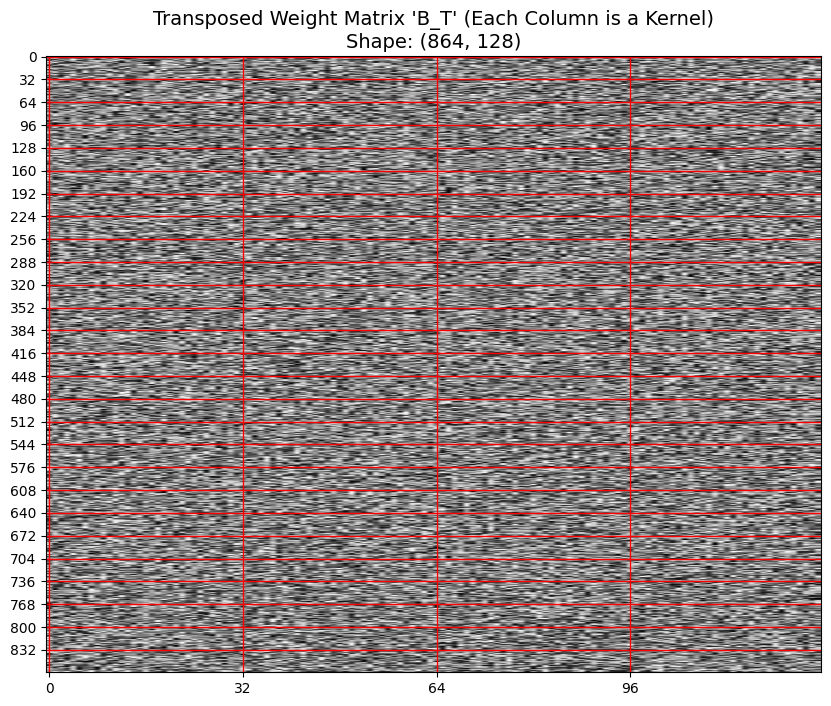

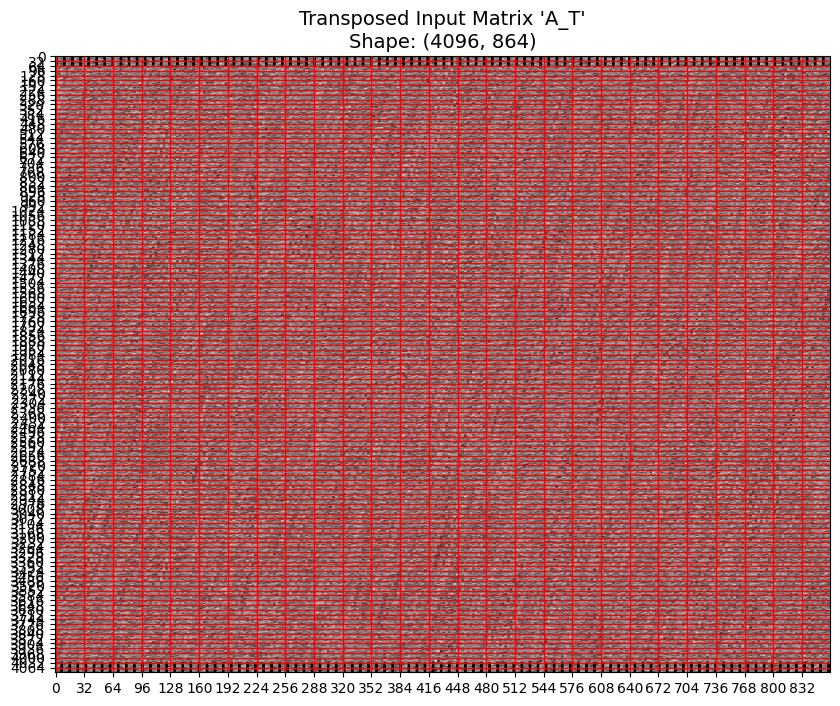

--- Step 2: Simulating Tiled Execution with Transposed Dataflow ---
Executing C_T[4096, 128] = A_T[4096, 864] @ B_T[864, 128]...


--- Transposed tiled execution complete. ---

--- Step 3: Verifying Tiled Computation Result ---
✅ SUCCESS: Tiled computation on transposed matrices is correct.
✅ SUCCESS: Final result matches the original (C = B @ A) computation.


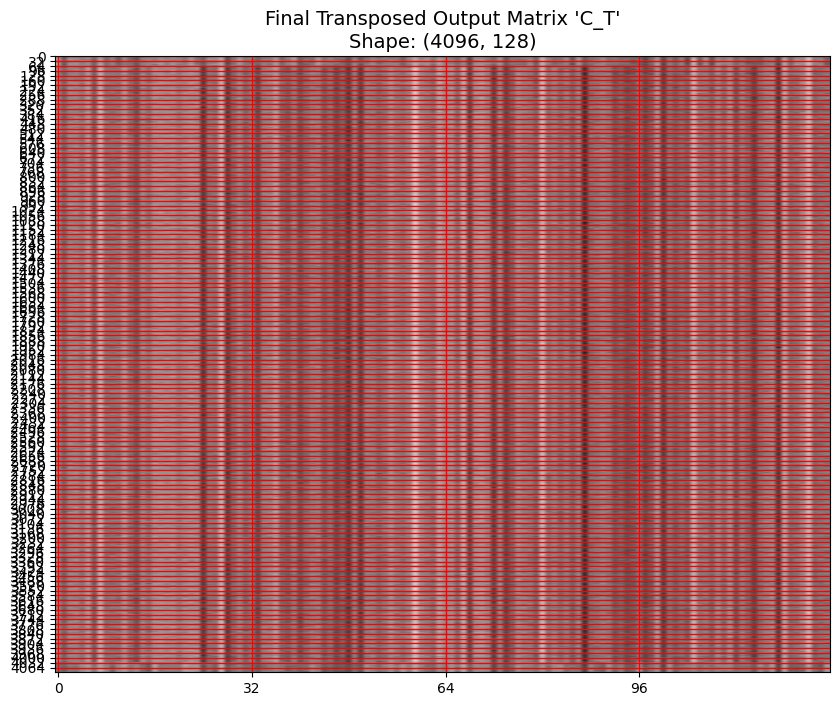

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

# --- 1. Hardware & Problem Definition ---

# Define the fixed hardware dimension
SYSTOLIC_ARRAY_DIM = 32

# Define a larger convolution problem that REQUIRES tiling
IN_HEIGHT = 64
IN_WIDTH = 64
IN_CHANNELS = 96
OUTPUT_CHANNELS = 128
KERNEL_SIZE = 3
STRIDE = 1
PADDING = 1

print(f"--- Hardware & Problem Setup ---")
print(f"Systolic Array Dimension: {SYSTOLIC_ARRAY_DIM}x{SYSTOLIC_ARRAY_DIM}")
print(f"Input Tensor: ({IN_CHANNELS}, {IN_HEIGHT}, {IN_WIDTH})")
print(f"Kernels: {OUTPUT_CHANNELS} kernels of size ({IN_CHANNELS}, {KERNEL_SIZE}, {KERNEL_SIZE})\n")

# --- 2. Helper Functions (Unchanged) ---

def im2col(input_data, K, S, P):
    C, H, W = input_data.shape
    out_h = (H + 2 * P - K) // S + 1
    out_w = (W + 2 * P - K) // S + 1
    padded_input = np.pad(input_data, ((0, 0), (P, P), (P, P)), 'constant')
    cols = np.zeros((C * K * K, out_h * out_w))
    col_idx = 0
    for y in range(out_h):
        for x in range(out_w):
            patch = padded_input[:, y*S:y*S+K, x*S:x*S+K]
            cols[:, col_idx] = patch.flatten()
            col_idx += 1
    return cols

def flatten_kernels(kernels):
    return kernels.reshape(kernels.shape[0], -1)

def show_matrix_with_tiles(matrix, title):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(matrix, cmap='gray', aspect='auto')
    ax.set_xticks(np.arange(0, matrix.shape[1], SYSTOLIC_ARRAY_DIM), minor=False)
    ax.set_yticks(np.arange(0, matrix.shape[0], SYSTOLIC_ARRAY_DIM), minor=False)
    ax.grid(which='major', color='r', linestyle='-', linewidth=1)
    ax.set_title(f"{title}\nShape: {matrix.shape}", fontsize=14)
    plt.show()

# --- 3. Transposed Logical Matrix Formulation ---
# Here we transpose the matrices to match your desired dataflow.

print("--- Step 1: Formulating Transposed Logical Matrices ---")
# Create random tensors for the simulation
input_tensor = np.random.randint(0, 256, size=(IN_CHANNELS, IN_HEIGHT, IN_WIDTH))
kernel_tensor = np.random.randint(-128, 128, size=(OUTPUT_CHANNELS, IN_CHANNELS, KERNEL_SIZE, KERNEL_SIZE))

# Create the standard logical matrices first
logical_A = im2col(input_tensor, KERNEL_SIZE, STRIDE, PADDING)
logical_B = flatten_kernels(kernel_tensor)

# --- NEW: Transpose the matrices to change the dataflow ---
logical_A_T = logical_A.T
logical_B_T = logical_B.T

# Define the dimensions for the new GEMM: C_T[N, M] = A_T[N, K] @ B_T[K, M]
N, K = logical_A_T.shape
K_b, M = logical_B_T.shape
assert K == K_b, "Matrix dimensions are incompatible!"

# Final output buffer is now for the transposed C
logical_C_T = np.zeros((N, M))

print("Original B Shape [M, K]:", logical_B.shape, "(Each ROW is a kernel)")
print("Transposed B_T Shape [K, M]:", logical_B_T.shape, "(Each COLUMN is a kernel) ✨")
print("Transposed A_T Shape [N, K]:", logical_A_T.shape)
print("Transposed C_T Shape [N, M]:", logical_C_T.shape, "\n")

# Visualize the new problem space with tile grids
show_matrix_with_tiles(logical_B_T, "Transposed Weight Matrix 'B_T' (Each Column is a Kernel)")
show_matrix_with_tiles(logical_A_T, "Transposed Input Matrix 'A_T'")

# --- 4. Tiled Execution with Transposed Matrices ---

print("--- Step 2: Simulating Tiled Execution with Transposed Dataflow ---")
print(f"Executing C_T[{N}, {M}] = A_T[{N}, {K}] @ B_T[{K}, {M}]...\n")

# Calculate number of tiles needed for each dimension
n_tiles = math.ceil(N / SYSTOLIC_ARRAY_DIM)
k_tiles = math.ceil(K / SYSTOLIC_ARRAY_DIM)
m_tiles = math.ceil(M / SYSTOLIC_ARRAY_DIM)

# Loop through the transposed output tiles
for n_idx in range(n_tiles):
    for m_idx in range(m_tiles):
        output_tile_accumulator = np.zeros((SYSTOLIC_ARRAY_DIM, SYSTOLIC_ARRAY_DIM))
        # Loop through the reduction (K) dimension
        for k_idx in range(k_tiles):
            # Calculate indices for slicing from TRANSPOSED matrices
            n_start, n_end = n_idx * SYSTOLIC_ARRAY_DIM, min((n_idx + 1) * SYSTOLIC_ARRAY_DIM, N)
            m_start, m_end = m_idx * SYSTOLIC_ARRAY_DIM, min((m_idx + 1) * SYSTOLIC_ARRAY_DIM, M)
            k_start, k_end = k_idx * SYSTOLIC_ARRAY_DIM, min((k_idx + 1) * SYSTOLIC_ARRAY_DIM, K)

            # Slice tiles
            a_tile_T = logical_A_T[n_start:n_end, k_start:k_end]
            b_tile_T = logical_B_T[k_start:k_end, m_start:m_end]

            # Pad tiles to 32x32 for the hardware
            padded_a_tile_T = np.zeros((SYSTOLIC_ARRAY_DIM, SYSTOLIC_ARRAY_DIM))
            padded_a_tile_T[:a_tile_T.shape[0], :a_tile_T.shape[1]] = a_tile_T

            padded_b_tile_T = np.zeros((SYSTOLIC_ARRAY_DIM, SYSTOLIC_ARRAY_DIM))
            padded_b_tile_T[:b_tile_T.shape[0], :b_tile_T.shape[1]] = b_tile_T
            
            # Systolic Array Operation: A_T tile comes from one side, B_T tile is stationary
            # We need to swap the order for numpy's matmul: B^T is now the second operand
            # The operation is C_T += A_T @ B_T
            partial_product = padded_a_tile_T @ padded_b_tile_T
            output_tile_accumulator += partial_product

        # Store the completed output tile back into the transposed output buffer
        h, w = n_end - n_start, m_end - m_start
        logical_C_T[n_start:n_end, m_start:m_end] = output_tile_accumulator[:h, :w]
        
print("\n--- Transposed tiled execution complete. ---")

# --- 5. Verification ---
print("\n--- Step 3: Verifying Tiled Computation Result ---")

# Verification using the transposed matrices
verification_C_T = logical_A_T @ logical_B_T

# Check if the tiled transposed result is correct
if np.allclose(logical_C_T, verification_C_T):
    print("✅ SUCCESS: Tiled computation on transposed matrices is correct.")
else:
    print("❌ FAILURE: Tiled computation on transposed matrices is incorrect.")

# --- Final Check: Compare with original (non-transposed) method ---
# Transpose the final result back to the original orientation
final_C_from_tiled_method = logical_C_T.T
# Calculate the original GEMM in one shot
original_verification_C = logical_B @ logical_A

if np.allclose(final_C_from_tiled_method, original_verification_C):
    print("✅ SUCCESS: Final result matches the original (C = B @ A) computation.")
else:
    print("❌ FAILURE: Final result does not match the original computation.")

# Show the final output matrix produced by the tiled transposed method
show_matrix_with_tiles(logical_C_T, "Final Transposed Output Matrix 'C_T'")